<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.69 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 19:19:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 14.7MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 143kB 47.6MB/s 
     |████████████████████████████████| 143kB 43.8MB/s 
     |████████████████████████████████| 174kB 52.3MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 1nhodh7l
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/1nhodh7l


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: wzabi3yv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 30s 93ms/step - loss: 0.1155 - mean_squared_error: 0.1155 - mean_absolute_error: 0.2638 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1390
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0844 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1338
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0540 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1627
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0912 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1047
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0087 - mean_squared_error: 0.008

epoch,30
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.01479
val_loss,0.00889
val_mean_squared_error,0.00889
val_mean_absolute_error,0.06979
_runtime,39
_timestamp,1626533146
_step,30
best_val_loss,0.00812


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▁▂▂▁▃▁▁▂▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▂▁▃▁▁▂▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▄▄▂▄▄▂▅▂▁▃▃▃▃▃▃▃▁▃▆▃▁▁▁▁▂▁▁
val_loss,▄▄▆▂▃▂▂▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁█▁▁▁▁▂▁▁▁
val_mean_squared_error,▄▄▆▂▃▂▂▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁█▁▁▁▁▂▁▁▁
val_mean_absolute_error,▄▄▆▃▃▂▃▃▂▂▂▂▁▂▂▃▂▂▂▁▁▂█▂▂▁▁▂▂▁▁
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅█████████████
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅█████████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: lp93ob0m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 1s 17ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - mean_absolute_error: 0.2289 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1955
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.0963 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1802
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.0986 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1752
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0841 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0883
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0125 - mean_squared_error: 0.

epoch,16
loss,0.00431
mean_squared_error,0.00431
mean_absolute_error,0.04182
val_loss,0.01667
val_mean_squared_error,0.01667
val_mean_absolute_error,0.10414
_runtime,7
_timestamp,1626533165
_step,16
best_val_loss,0.01237


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▁▂▁▂▁▁
val_loss,█▇▆▁▁▃▁▃▁▂▂▁▂▂▂▃▂
val_mean_squared_error,█▇▆▁▁▃▁▃▁▂▂▁▂▂▂▃▂
val_mean_absolute_error,█▇▇▁▁▄▁▃▁▃▂▁▂▃▂▄▂
_runtime,▁▃▃▃▃▃▆▆▆▆▆▆█████
_timestamp,▁▃▃▃▃▃▆▆▆▆▆▆█████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 0bbv9pnb with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 53ms/step - loss: 0.2780 - mean_squared_error: 0.2780 - mean_absolute_error: 0.4820 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - val_mean_absolute_error: 0.2323
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0788 - mean_squared_error: 0.0788 - mean_absolute_error: 0.2450 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1419
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0604 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1538
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0496 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1475
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 

epoch,99
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.01609
val_loss,0.00516
val_mean_squared_error,0.00516
val_mean_absolute_error,0.05565
_runtime,13
_timestamp,1626533190
_step,99
best_val_loss,0.00482


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: reqsdx7f with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 30ms/step - loss: 0.3796 - mean_squared_error: 0.3796 - mean_absolute_error: 0.4803 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1060
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0929 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0895
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0420 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0619
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0282 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0598
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.

epoch,49
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.01461
val_loss,0.00327
val_mean_squared_error,0.00327
val_mean_absolute_error,0.04605
_runtime,11
_timestamp,1626533214
_step,49
best_val_loss,0.0026


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
val_mean_squared_error,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
val_mean_absolute_error,█▆▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c2q6a8l6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 1s 15ms/step - loss: 0.0786 - mean_squared_error: 0.0786 - mean_absolute_error: 0.2012 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1359
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0365 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1011
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0297 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0768
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0248 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0614
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_squared_erro

epoch,19
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02013
val_loss,0.01069
val_mean_squared_error,0.01069
val_mean_absolute_error,0.07538
_runtime,8
_timestamp,1626533232
_step,19
best_val_loss,0.00663


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁
val_loss,█▅▃▁▂▂▂▁▁▁▂▂▂▃▃▂▂▃▄▂
val_mean_squared_error,█▅▃▁▂▂▂▁▁▁▂▂▂▃▃▂▂▃▄▂
val_mean_absolute_error,█▅▂▁▂▂▂▁▁▁▂▂▂▃▃▂▂▄▄▂
_runtime,▁▁▁▃▃▃▃▃▆▆▆▆▆▆██████
_timestamp,▁▁▁▃▃▃▃▃▆▆▆▆▆▆██████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hibscmvs with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 0.3543 - mean_squared_error: 0.3543 - mean_absolute_error: 0.4371 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1541
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0533 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1641
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1580 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1528
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1127 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1640
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - mean_squared_error: 0.0239 

epoch,60
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.01453
val_loss,0.00408
val_mean_squared_error,0.00408
val_mean_absolute_error,0.05133
_runtime,10
_timestamp,1626533252
_step,60
best_val_loss,0.00276


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▄▄▃▃▃▃▃▂▂▂▂▂▁▃▁▃▂▂▂▁▂▂▂▂▁▂▁▁▂▂▁▂▁▁▂▁▁
val_loss,▅▇▇█▃▇▂▃▂▄▂▂▁▁▂▁▁▁▁▂▁▁▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▇▇█▃▇▂▃▂▄▂▂▁▁▂▁▁▁▁▂▁▁▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▇▇█▄█▃▄▃▅▃▃▂▂▃▂▂▁▂▃▂▁▂▄▁▁▂▁▁▂▃▂▂▁▁▂▂▂▂▂
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7rqm03xo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 55ms/step - loss: 0.2727 - mean_squared_error: 0.2727 - mean_absolute_error: 0.4651 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1255
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0624 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1381
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0471 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1300
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0439 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1193
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - me

epoch,43
loss,0.00168
mean_squared_error,0.00168
mean_absolute_error,0.02643
val_loss,0.00654
val_mean_squared_error,0.00654
val_mean_absolute_error,0.0599
_runtime,9
_timestamp,1626533277
_step,43
best_val_loss,0.00475


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▇█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▇█▇▆▆▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jqfgyhvr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 57ms/step - loss: 1.0224 - mean_squared_error: 1.0224 - mean_absolute_error: 0.8744 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1191
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0725 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0913
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0552 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0913
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0531 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0788
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 

epoch,99
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.01408
val_loss,0.00343
val_mean_squared_error,0.00343
val_mean_absolute_error,0.04603
_runtime,14
_timestamp,1626533302
_step,99
best_val_loss,0.00343


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▅▂▂▂▂▂▃▂▂▂▂▂▂▁▃▂▂▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁
val_mean_squared_error,█▅▃▅▂▂▂▂▂▃▂▂▂▂▂▂▁▃▂▂▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▅▃▅▃▃▂▂▂▃▂▂▂▂▂▃▂▃▂▂▂▁▁▂▂▁▂▁▂▁▁▂▁▁▁▁▁▂▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: naoucmod with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 47ms/step - loss: 0.1184 - mean_squared_error: 0.1184 - mean_absolute_error: 0.2298 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1148
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0986 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1057
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0679 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1279
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0763 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0924
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_erro

epoch,20
loss,0.00384
mean_squared_error,0.00384
mean_absolute_error,0.04918
val_loss,0.00958
val_mean_squared_error,0.00958
val_mean_absolute_error,0.07311
_runtime,9
_timestamp,1626533323
_step,20
best_val_loss,0.008


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▃▃▄▄▄▂▁▂▃▁▃▃▂▃▂▁▃
val_loss,▆▅█▃▃▅▅▃▂▁▁▂▂▁▂▁▂▂▂▃▂
val_mean_squared_error,▆▅█▃▃▅▅▃▂▁▁▂▂▁▂▁▂▂▂▃▂
val_mean_absolute_error,▇▆█▄▄▅▅▃▂▂▁▂▃▂▄▂▂▂▃▃▂
_runtime,▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 5eofkoqc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0916 - mean_squared_error: 0.0916 - mean_absolute_error: 0.2267 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1120
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0518 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0923
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0328 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0757
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0263 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0689
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_erro

epoch,86
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.01925
val_loss,0.00267
val_mean_squared_error,0.00267
val_mean_absolute_error,0.03961
_runtime,17
_timestamp,1626533351
_step,86
best_val_loss,0.00263


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▂▂▂▃▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kjapwmvr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 30ms/step - loss: 0.2395 - mean_squared_error: 0.2395 - mean_absolute_error: 0.4293 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1335
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0516 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1362
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0446 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1271
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0359 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1227
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_erro

epoch,68
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.01559
val_loss,0.00366
val_mean_squared_error,0.00366
val_mean_absolute_error,0.04654
_runtime,16
_timestamp,1626533378
_step,68
best_val_loss,0.00336


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: copd9dub with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 16ms/step - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.1896 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1383
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0353 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1200
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0343 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0963
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0276 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0762
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_erro

epoch,20
loss,0.00131
mean_squared_error,0.00131
mean_absolute_error,0.01863
val_loss,0.00542
val_mean_squared_error,0.00542
val_mean_absolute_error,0.05741
_runtime,11
_timestamp,1626533400
_step,20
best_val_loss,0.00461


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▃▂▂▂▃▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆███
_timestamp,▁▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: dbd6cf5y with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 2s 50ms/step - loss: 0.1162 - mean_squared_error: 0.1162 - mean_absolute_error: 0.2898 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1429
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0515 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1415
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0433 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1387
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0381 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1283
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.0060

epoch,58
loss,0.00162
mean_squared_error,0.00162
mean_absolute_error,0.02308
val_loss,0.00578
val_mean_squared_error,0.00578
val_mean_absolute_error,0.05668
_runtime,11
_timestamp,1626533425
_step,58
best_val_loss,0.00539


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,███▆▆▆▅▄▄▃▃▄▃▂▂▃▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,███▆▆▆▅▄▄▃▃▄▃▂▂▃▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,███▆▆▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▂▁▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p65ay4sp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 16ms/step - loss: 0.1690 - mean_squared_error: 0.1690 - mean_absolute_error: 0.3055 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1258
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0467 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1123
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0379 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1091
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0338 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1078
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_squared_erro

epoch,38
loss,0.00145
mean_squared_error,0.00145
mean_absolute_error,0.02019
val_loss,0.00481
val_mean_squared_error,0.00481
val_mean_absolute_error,0.05113
_runtime,14
_timestamp,1626533450
_step,38
best_val_loss,0.00441


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▄▃▃▃▃▃▃▂▂▂▂▃▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▇▇▇▄▃▃▃▃▃▃▂▂▂▂▃▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▆▆▄▄▃▃▃▃▃▂▂▂▂▄▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dtz7v7uy with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1462 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1362
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0762 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1823
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0787 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1022
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0981 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0964
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0117 - mean_squared_erro

epoch,51
loss,0.0016
mean_squared_error,0.0016
mean_absolute_error,0.02191
val_loss,0.00327
val_mean_squared_error,0.00327
val_mean_absolute_error,0.04524
_runtime,12
_timestamp,1626533473
_step,51
best_val_loss,0.0026


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▄▆▄▆▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁
val_loss,▅█▃▃▂▃▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▃▃▂▃▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▄▄▃▄▃▃▃▂▂▂▂▂▂▁▂▁▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5q1jdpru with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 0.1518 - mean_squared_error: 0.1518 - mean_absolute_error: 0.2294 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1164
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0886 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0954
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0869 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0787
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0660 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0705
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_squared_erro

epoch,52
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.02591
val_loss,0.00349
val_mean_squared_error,0.00349
val_mean_absolute_error,0.04625
_runtime,16
_timestamp,1626533500
_step,52
best_val_loss,0.00293


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▂▁▂
val_loss,█▆▄▂▂▂▅▂▂▄▂▂▁▃▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▂▂▁▁▂▂▁▂▁▁▁
val_mean_squared_error,█▆▄▂▂▂▅▂▂▄▂▂▁▃▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▂▂▁▁▂▂▁▂▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▅▃▂▅▂▂▁▃▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▂▂▁▁▂▄▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ncv51b3g with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.1106 - mean_squared_error: 0.1106 - mean_absolute_error: 0.2512 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1396
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0622 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1226
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0365 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1017
Epoch 4/200
16/16 [==============================] - 0s 29ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0279 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0901
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_err

epoch,116
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.01368
val_loss,0.00274
val_mean_squared_error,0.00274
val_mean_absolute_error,0.04021
_runtime,22
_timestamp,1626533534
_step,116
best_val_loss,0.00272


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xwe5th64 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 30ms/step - loss: 0.1848 - mean_squared_error: 0.1848 - mean_absolute_error: 0.3240 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1420
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0690 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0852
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0383 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0708
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0226 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0639
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_erro

epoch,64
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.01433
val_loss,0.00252
val_mean_squared_error,0.00252
val_mean_absolute_error,0.03877
_runtime,16
_timestamp,1626533565
_step,64
best_val_loss,0.0025


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zdspehvp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 0.2267 - mean_squared_error: 0.2267 - mean_absolute_error: 0.3637 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1481
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0555 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1353
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0506 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1261
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0687 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1197
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0102 - mean_squared_error: 0.0102 

epoch,45
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.03651
val_loss,0.01125
val_mean_squared_error,0.01125
val_mean_absolute_error,0.07791
_runtime,10
_timestamp,1626533586
_step,45
best_val_loss,0.00779


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▃▂▃▁▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▂▁▂▁▁▂▂▁▁▂▂▂▁▂▁▂▂
val_loss,█▇▆▅▅▅▅▃▃▄▃▃▄▃▂▃▁▁▁▂▂▂▂▂▂▂▁▂▁▁▃▁▃▁▂▁▂▂▁▂
val_mean_squared_error,█▇▆▅▅▅▅▃▃▄▃▃▄▃▂▃▁▁▁▂▂▂▂▂▂▂▁▂▁▁▃▁▃▁▂▁▂▂▁▂
val_mean_absolute_error,█▇▆▆▅▅▅▃▃▃▃▃▄▂▁▃▁▂▁▁▁▁▂▂▂▁▁▂▁▁▂▁▂▁▂▁▂▂▁▂
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆██████████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆██████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: fo0fdlaw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 29ms/step - loss: 0.1910 - mean_squared_error: 0.1910 - mean_absolute_error: 0.3606 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1403
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0422 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1280
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0372 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1096
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0361 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1010
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_erro

epoch,40
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.02505
val_loss,0.0048
val_mean_squared_error,0.0048
val_mean_absolute_error,0.05207
_runtime,13
_timestamp,1626533614
_step,40
best_val_loss,0.00404


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▂▂▂▂▂▃▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: n5jkw398 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 2s 52ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - mean_absolute_error: 0.2022 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1303
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0916 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1375
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0570 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1190
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0435 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1047
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 

epoch,100
loss,0.0015
mean_squared_error,0.0015
mean_absolute_error,0.02167
val_loss,0.00353
val_mean_squared_error,0.00353
val_mean_absolute_error,0.04438
_runtime,16
_timestamp,1626533643
_step,100
best_val_loss,0.00283


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g0gpyzv4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 29ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_error: 0.1850 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1483
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0536 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1594
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0797 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1034
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0679 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1014
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.

epoch,49
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02041
val_loss,0.00854
val_mean_squared_error,0.00854
val_mean_absolute_error,0.06717
_runtime,14
_timestamp,1626533670
_step,49
best_val_loss,0.00747


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▅▂▂▂▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▅▂▂▂▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇▃▃▄▃▃▃▂▂▁▂▅▁▁▂▂▂▃▂▃▂▂▃▂▁▂▂█▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▆█▃▃▂▄▂▃▂▂▂▃▂▂▂▂▂▃▂▃▂▃▂▂▂▂▂▄▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▃▃▂▄▂▃▂▂▂▃▂▂▂▂▂▃▂▃▂▃▂▂▂▂▂▄▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▄▄▄▅▃▄▃▂▄▄▃▃▃▃▃▃▂▃▂▄▂▂▃▂▂▅▂▂▁▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: snzh31h8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 29ms/step - loss: 0.0786 - mean_squared_error: 0.0786 - mean_absolute_error: 0.1865 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1460
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0647 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1130
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0707 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0919
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0571 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0926
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0101 - mean_squared_erro

epoch,25
loss,0.00341
mean_squared_error,0.00341
mean_absolute_error,0.04386
val_loss,0.00976
val_mean_squared_error,0.00976
val_mean_absolute_error,0.07006
_runtime,11
_timestamp,1626533696
_step,25
best_val_loss,0.00839


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▃▂▂▁▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁
mean_squared_error,█▃▃▂▂▁▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁
mean_absolute_error,█▄▅▃▅▂▄▄▂▄▂▄▃▃▁▂▂▂▂▁▂▄▂▃▁▃
val_loss,█▄▃▃▃▁▃▂▃▂▂▂▅▂▁▁▃▂▁▂▂▅▁▁▂▁
val_mean_squared_error,█▄▃▃▃▁▃▂▃▂▂▂▅▂▁▁▃▂▁▂▂▅▁▁▂▁
val_mean_absolute_error,█▅▃▃▄▂▄▃▃▃▃▃▆▃▁▁▃▂▂▂▂▆▁▁▂▁
_runtime,▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r9cpea0f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 58ms/step - loss: 10.6280 - mean_squared_error: 10.6280 - mean_absolute_error: 2.1375 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1470
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0671 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1322
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0480 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1200
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0397 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1125
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0167 - mean_squared_error: 0.01

epoch,30
loss,0.02052
mean_squared_error,0.02052
mean_absolute_error,0.1222
val_loss,0.01142
val_mean_squared_error,0.01142
val_mean_absolute_error,0.08668
_runtime,9
_timestamp,1626533748
_step,30
best_val_loss,0.01021


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▂▂▁▂▂▂▂▂▁▂▂▁▁▃▁▁▁▁▁▄▁▁▁▁▁▁
val_loss,▂▂▁▁▇▁▇▁▂▃▃▂▅▁█▁▂▃▃▁▁▂▁▂▄▂▂▁▄▁▁
val_mean_squared_error,▂▂▁▁▇▁▇▁▂▃▃▂▅▁█▁▂▃▃▁▁▂▁▂▄▂▂▁▄▁▁
val_mean_absolute_error,▃▂▂▂▇▂▇▁▃▄▅▃▆▂█▁▂▄▄▁▁▃▁▃▅▃▂▁▅▁▁
_runtime,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅██████████
_timestamp,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅██████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: ow2lwwz7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.1605 - mean_squared_error: 0.1605 - mean_absolute_error: 0.1792 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1602
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0909 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1113
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0576 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1036
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0904 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0725
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_squared_error: 0.

epoch,26
loss,0.0025
mean_squared_error,0.0025
mean_absolute_error,0.03426
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.04218
_runtime,13
_timestamp,1626533775
_step,26
best_val_loss,0.00286


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▅▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂
val_loss,█▄▄▂▂▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▂▂▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▃▃▂▃▂▃▂▂▃▁▂▂▂▁▂▁▁▂▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: h6whfpop with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 59ms/step - loss: 0.2426 - mean_squared_error: 0.2426 - mean_absolute_error: 0.4359 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1344
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1102 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1605
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0754 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1234
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0857 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1260
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064 

epoch,68
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.01214
val_loss,0.00347
val_mean_squared_error,0.00347
val_mean_absolute_error,0.04533
_runtime,14
_timestamp,1626533803
_step,68
best_val_loss,0.00341


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▅▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ayo602wu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.1077 - mean_squared_error: 0.1077 - mean_absolute_error: 0.2177 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1349
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0660 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1086
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0709 - val_loss: 0.0458 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1667
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0838 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1697
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_squared_erro

epoch,77
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.02833
val_loss,0.00972
val_mean_squared_error,0.00972
val_mean_absolute_error,0.06913
_runtime,24
_timestamp,1626533845
_step,77
best_val_loss,0.00612


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▅▄█▄▄▅▃▃▃▅▄▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▃▂▂▃▂▂▁▂▂▂▁▂
val_mean_squared_error,▅▄█▄▄▅▃▃▃▅▄▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▃▂▂▃▂▂▁▂▂▂▁▂
val_mean_absolute_error,▆▄█▅▄▅▄▃▄▅▄▃▃▃▃▃▂▂▃▂▂▃▃▂▂▂▃▂▄▂▂▃▂▂▁▂▂▂▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3liek7gg with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 15ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - mean_absolute_error: 0.1934 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1026
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0879 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0923
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0897 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0960
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0596 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0609
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_erro

epoch,40
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.02517
val_loss,0.00423
val_mean_squared_error,0.00423
val_mean_absolute_error,0.04706
_runtime,16
_timestamp,1626533877
_step,40
best_val_loss,0.00271


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▄▄▃▃▃▂▃▃▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▁▂▂▁▂▁▁▁▁▂▂▁▁▁
val_loss,█▇█▃▃▄▂▄▂▂▂▁▂▁▅▃▁▂▁▂▂▆▁▄▁▁▁▂▂▄▁▁▂▂▁▁▄▂▂▂
val_mean_squared_error,█▇█▃▃▄▂▄▂▂▂▁▂▁▅▃▁▂▁▂▂▆▁▄▁▁▁▂▂▄▁▁▂▂▁▁▄▂▂▂
val_mean_absolute_error,█▇▇▃▃▅▂▅▂▂▃▂▂▂▅▃▁▃▁▂▃▆▂▅▁▁▁▃▂▅▁▁▂▃▁▂▄▂▂▂
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: etqhodcs with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - mean_absolute_error: 0.1721 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1184
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0519 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0825
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0351 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0709
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0230 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0660
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_erro

epoch,76
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.01335
val_loss,0.00264
val_mean_squared_error,0.00264
val_mean_absolute_error,0.04028
_runtime,18
_timestamp,1626533909
_step,76
best_val_loss,0.00259


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jx34b8f1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 15ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1282 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0956
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0606 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0788
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0644 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0751
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0564 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0711
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_erro

epoch,45
loss,0.00133
mean_squared_error,0.00133
mean_absolute_error,0.02032
val_loss,0.00292
val_mean_squared_error,0.00292
val_mean_absolute_error,0.04246
_runtime,16
_timestamp,1626533945
_step,45
best_val_loss,0.00237


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▄▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▅▃▃▂▂▂▂▂▂▁▂▂▃▁▄▁▂▂▂▁▁▁▂▁▂▁▂▁▂▁▁▂▁▁▂▁
val_mean_squared_error,█▆▄▄▅▃▃▂▂▂▂▂▂▁▂▂▃▁▄▁▂▂▂▁▁▁▂▁▂▁▂▁▂▁▁▂▁▁▂▁
val_mean_absolute_error,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▄▂▄▂▂▂▂▁▂▁▃▁▃▁▂▁▂▂▂▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 1apb9y86 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 30ms/step - loss: 0.1843 - mean_squared_error: 0.1843 - mean_absolute_error: 0.3664 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1601
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0452 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1390
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0381 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1257
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0316 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1133
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.

epoch,28
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.01458
val_loss,0.00526
val_mean_squared_error,0.00526
val_mean_absolute_error,0.05533
_runtime,12
_timestamp,1626533979
_step,28
best_val_loss,0.00511


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▆▅▄▃▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█████
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: nyubzejh with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 55ms/step - loss: 0.1502 - mean_squared_error: 0.1502 - mean_absolute_error: 0.3066 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1447
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1211 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1278
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0482 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1241
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0336 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1160
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - me

epoch,49
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.01303
val_loss,0.00386
val_mean_squared_error,0.00386
val_mean_absolute_error,0.04704
_runtime,13
_timestamp,1626534008
_step,49
best_val_loss,0.00352


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▄▃▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2hz8etmd with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 55ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1671 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1240
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0871 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1033
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0736 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0931
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0736 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0835
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0073 - mean_squared_error: 0.00

epoch,68
loss,0.00312
mean_squared_error,0.00312
mean_absolute_error,0.04293
val_loss,0.00447
val_mean_squared_error,0.00447
val_mean_absolute_error,0.05414
_runtime,15
_timestamp,1626534038
_step,68
best_val_loss,0.0027


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▁▃▁▂▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▄▃▁▃▁▂▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▆▅▂▅▂▃▂▁▄▂▂▂▂▄▁▁▂▁▁▂▁▁▁▁▃▂▁▁▁▁▂▂▁▁▂▁▁▁▃
val_loss,█▆▄▃▅▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▆▄▃▅▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▆▅▃▅▂▄▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sr9g3737 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 54ms/step - loss: 0.2467 - mean_squared_error: 0.2467 - mean_absolute_error: 0.4307 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1435
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0658 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1516
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0503 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1411
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0442 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1340
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - me

epoch,49
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.03266
val_loss,0.00779
val_mean_squared_error,0.00779
val_mean_absolute_error,0.06336
_runtime,12
_timestamp,1626534065
_step,49
best_val_loss,0.00686


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▆▆▆▆▄▄▆▄▅▃▃▃▃▂▄▃▂▃▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▇█▇▆▆▆▆▆▄▄▆▄▅▃▃▃▃▂▄▃▂▃▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▄▃▂▃▂▂▁▂▂▁▁▁▁▂▂▁▂▁▁▁▂▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xz5r53i0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 55ms/step - loss: 0.3024 - mean_squared_error: 0.3024 - mean_absolute_error: 0.5032 - val_loss: 0.1082 - val_mean_squared_error: 0.1082 - val_mean_absolute_error: 0.2573
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - mean_absolute_error: 0.2957 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1400
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0788 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.1952
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1256 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1530
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - me

epoch,49
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.01427
val_loss,0.00394
val_mean_squared_error,0.00394
val_mean_absolute_error,0.04648
_runtime,13
_timestamp,1626534093
_step,49
best_val_loss,0.00387


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v86j0t1k with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 53ms/step - loss: 7.9228 - mean_squared_error: 7.9228 - mean_absolute_error: 1.8582 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.2158
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1391 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1728
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0799 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1430
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0515 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1293
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0108 - mean_squared_error: 0.0108

epoch,24
loss,0.01328
mean_squared_error,0.01328
mean_absolute_error,0.09907
val_loss,0.01354
val_mean_squared_error,0.01354
val_mean_absolute_error,0.09211
_runtime,11
_timestamp,1626534124
_step,24
best_val_loss,0.01081


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▂▁▁▁▂▃▁▁▁▁▁▃▂▁▂▁▂▂▂▁
val_loss,▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁█▁▁
val_mean_squared_error,▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁█▁▁
val_mean_absolute_error,▂▂▂▂▃▁▃▁▂▃▁▂▁▁▁▂▃▁▄▁▁▁█▁▁
_runtime,▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: a2ud09s4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 58ms/step - loss: 0.3016 - mean_squared_error: 0.3016 - mean_absolute_error: 0.4419 - val_loss: 0.0683 - val_mean_squared_error: 0.0683 - val_mean_absolute_error: 0.2213
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1463 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1097
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0799 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1111
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0524 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0922
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052

epoch,99
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.01304
val_loss,0.00299
val_mean_squared_error,0.00299
val_mean_absolute_error,0.04193
_runtime,17
_timestamp,1626534157
_step,99
best_val_loss,0.00299


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4phkyvc9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 27ms/step - loss: 0.1036 - mean_squared_error: 0.1036 - mean_absolute_error: 0.2083 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1167
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0517 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1024
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0489 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0940
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0356 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0876
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.

epoch,46
loss,0.00189
mean_squared_error,0.00189
mean_absolute_error,0.02666
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.0533
_runtime,14
_timestamp,1626534197
_step,46
best_val_loss,0.00482


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▂▁▁▁
val_loss,█▆▅▅▄▄▄▄▂▃▄▃▂▁▁▄▃▃▂▃▂▂▁▁▃▃▃▂▂▁▂▁▂▁▂▂▂▂▂▁
val_mean_squared_error,█▆▅▅▄▄▄▄▂▃▄▃▂▁▁▄▃▃▂▃▂▂▁▁▃▃▃▂▂▁▂▁▂▁▂▂▂▂▂▁
val_mean_absolute_error,█▆▆▅▄▄▃▄▃▃▃▄▃▁▂▅▄▃▂▃▃▂▁▁▄▃▃▂▂▂▃▁▂▁▂▂▁▂▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rivi2wxi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 56ms/step - loss: 0.2678 - mean_squared_error: 0.2678 - mean_absolute_error: 0.4581 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1390
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1058 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1751
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0835 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1376
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0970 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1415
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - m

epoch,49
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.01313
val_loss,0.00376
val_mean_squared_error,0.00376
val_mean_absolute_error,0.04583
_runtime,13
_timestamp,1626534246
_step,49
best_val_loss,0.00352


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▅▅▄▄▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▅▅▅▄▄▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▆▆▅▅▅▄▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nynkxrrs with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 28ms/step - loss: 0.1144 - mean_squared_error: 0.1144 - mean_absolute_error: 0.1773 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1204
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0886 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1012
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0928 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1196
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0832 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1152
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.

epoch,49
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.02657
val_loss,0.00259
val_mean_squared_error,0.00259
val_mean_absolute_error,0.03973
_runtime,16
_timestamp,1626534283
_step,49
best_val_loss,0.00236


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆█▇▅▅▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▂▁▁▂▂
val_loss,█▆██▄▃▃▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆██▄▃▃▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆██▄▃▄▃▃▄▃▂▂▃▃▂▂▂▂▁▂▁▁▁▁▂▂▁▁▂▁▂▂▂▂▁▁▂▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7j4cbs3m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - mean_absolute_error: 0.2599 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1443
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0514 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1416
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0380 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1318
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0377 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1179
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.

epoch,44
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.01393
val_loss,0.00376
val_mean_squared_error,0.00376
val_mean_absolute_error,0.0465
_runtime,19
_timestamp,1626534330
_step,44
best_val_loss,0.0035


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xoztobfo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 54ms/step - loss: 0.1895 - mean_squared_error: 0.1895 - mean_absolute_error: 0.3301 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1327
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0482 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1209
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0513 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1155
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0525 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1113
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.007

epoch,41
loss,0.00292
mean_squared_error,0.00292
mean_absolute_error,0.03824
val_loss,0.00971
val_mean_squared_error,0.00971
val_mean_absolute_error,0.07371
_runtime,12
_timestamp,1626534381
_step,41
best_val_loss,0.00657


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▃▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂
val_loss,█▇▆▆▆▇▇▆▆▇▃▅▃▃▂▂▃▂▃▂▂▂▃▂▁▂▁▂▂▁▁▁▂▂▁▁▂▁▂▂
val_mean_squared_error,█▇▆▆▆▇▇▆▆▇▃▅▃▃▂▂▃▂▃▂▂▂▃▂▁▂▁▂▂▁▁▁▂▂▁▁▂▁▂▂
val_mean_absolute_error,█▇▆▆▆▆▆▆▅▆▄▅▃▃▂▂▃▂▄▁▂▂▃▂▁▁▂▃▂▁▁▁▂▂▁▁▂▂▂▂
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: awr2662w with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 58ms/step - loss: 0.2024 - mean_squared_error: 0.2024 - mean_absolute_error: 0.3898 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1531
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1354 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1428
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0589 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1212
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0807 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1274
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - me

epoch,49
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.01258
val_loss,0.00332
val_mean_squared_error,0.00332
val_mean_absolute_error,0.0434
_runtime,13
_timestamp,1626534411
_step,49
best_val_loss,0.0031


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇████████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2gkz1nw3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - mean_absolute_error: 0.1902 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1327
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0431 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1188
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0301 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1043
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0331 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0814
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_erro

epoch,25
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02184
val_loss,0.00417
val_mean_squared_error,0.00417
val_mean_absolute_error,0.04722
_runtime,14
_timestamp,1626534444
_step,25
best_val_loss,0.00368


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▂
val_loss,█▇▆▄▃▃▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▇▆▄▃▃▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▆▄▃▃▃▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i4o01l5k with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1640 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0848
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0444 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0675
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0276 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0618
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0201 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0586
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_erro

epoch,65
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.01756
val_loss,0.00278
val_mean_squared_error,0.00278
val_mean_absolute_error,0.04078
_runtime,18
_timestamp,1626534503
_step,65
best_val_loss,0.00267


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▅▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 53xufg2w with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 51ms/step - loss: 0.3478 - mean_squared_error: 0.3478 - mean_absolute_error: 0.4850 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - val_mean_absolute_error: 0.2636
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1799 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1241
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0901 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1292
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0620 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1028
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051

epoch,99
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.01192
val_loss,0.00298
val_mean_squared_error,0.00298
val_mean_absolute_error,0.04251
_runtime,19
_timestamp,1626534541
_step,99
best_val_loss,0.00298


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rg4tpflv with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.4477 - mean_squared_error: 0.4477 - mean_absolute_error: 0.4360 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0827
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0688 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1094
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.1124 - mean_squared_error: 0.1124 - mean_absolute_error: 0.2231 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0686
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0260 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0548
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,27
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.02041
val_loss,0.00314
val_mean_squared_error,0.00314
val_mean_absolute_error,0.04285
_runtime,17
_timestamp,1626534572
_step,27
best_val_loss,0.00263


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
mean_absolute_error,▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: gedvidgj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 26ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1571 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0860
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0687 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0732
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0335 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0822
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0560 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0632
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02125
val_loss,0.00289
val_mean_squared_error,0.00289
val_mean_absolute_error,0.04116
_runtime,16
_timestamp,1626534603
_step,49
best_val_loss,0.0027


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▂▃▃▄▁▂▁▂▁▁▂▁▁▂▂▂▂▁▂▁▂▁▁▁▃▁▁▁▁▁▁▂▁▁▂
val_loss,▇▆█▄▄▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▆█▄▄▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▇▅▄▄▄▃▃▂▃▂▂▂▂▃▂▂▂▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 92juhlcj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 28ms/step - loss: 0.1904 - mean_squared_error: 0.1904 - mean_absolute_error: 0.3684 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - val_mean_absolute_error: 0.2097
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1145 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1319
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0489 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1313
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0434 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1211
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_squared_erro

epoch,41
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.01396
val_loss,0.00424
val_mean_squared_error,0.00424
val_mean_absolute_error,0.04827
_runtime,15
_timestamp,1626534634
_step,41
best_val_loss,0.00375


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 85efcwqt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 18ms/step - loss: 0.1888 - mean_squared_error: 0.1888 - mean_absolute_error: 0.2684 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1541
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1288 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1164
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0979 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0967
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0905 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1096
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0121 - mean_squared_erro

epoch,76
loss,0.00198
mean_squared_error,0.00198
mean_absolute_error,0.02881
val_loss,0.00719
val_mean_squared_error,0.00719
val_mean_absolute_error,0.06193
_runtime,25
_timestamp,1626534673
_step,76
best_val_loss,0.00673


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▅▄▂▂▂▂▃▂▂▂▃▂▃▂▃▂▂▃▂▂▂▂▂▁▁▃▂▂▁▂▁▁▂▂▁▁▁
val_mean_squared_error,█▄▄▅▄▂▂▂▂▃▂▂▂▃▂▃▂▃▂▂▃▂▂▂▂▂▁▁▃▂▂▁▂▁▁▂▂▁▁▁
val_mean_absolute_error,█▅▅▆▄▃▃▃▃▄▂▃▂▄▂▃▂▃▂▂▃▂▂▂▂▃▂▂▄▂▂▁▂▁▁▂▂▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qk9ufw1b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 29ms/step - loss: 0.1668 - mean_squared_error: 0.1668 - mean_absolute_error: 0.3291 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1281
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0472 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1263
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0393 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1115
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0404 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1094
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_erro

epoch,38
loss,0.00172
mean_squared_error,0.00172
mean_absolute_error,0.02355
val_loss,0.00553
val_mean_squared_error,0.00553
val_mean_absolute_error,0.05473
_runtime,14
_timestamp,1626534704
_step,38
best_val_loss,0.0048


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▇▅▅▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▇▅▅▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▅▄▃▃▃▃▃▃▂▂▃▂▂▂▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇███████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ocluu7zm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 17ms/step - loss: 0.1056 - mean_squared_error: 0.1056 - mean_absolute_error: 0.2381 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1274
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0439 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1108
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0382 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1072
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0363 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1035
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_squared_erro

epoch,40
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.01788
val_loss,0.00707
val_mean_squared_error,0.00707
val_mean_absolute_error,0.06302
_runtime,17
_timestamp,1626534737
_step,40
best_val_loss,0.0045


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▄▄▄▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_squared_error,█▆▆▆▄▄▄▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▆▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: dtqjzwaz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 51ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - mean_absolute_error: 0.3151 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1353
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1011 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1175
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0632 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1191
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0539 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0967
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mea

epoch,49
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.0139
val_loss,0.00318
val_mean_squared_error,0.00318
val_mean_absolute_error,0.04527
_runtime,14
_timestamp,1626534766
_step,49
best_val_loss,0.00318


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o9yoyw55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 52ms/step - loss: 0.4079 - mean_squared_error: 0.4079 - mean_absolute_error: 0.5820 - val_loss: 0.1163 - val_mean_squared_error: 0.1163 - val_mean_absolute_error: 0.2665
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1139 - mean_squared_error: 0.1139 - mean_absolute_error: 0.2949 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1390
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0745 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.1934
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1344 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1518
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0091 - mean_squared_error: 0.0091

epoch,99
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.0118
val_loss,0.00329
val_mean_squared_error,0.00329
val_mean_absolute_error,0.0436
_runtime,18
_timestamp,1626534798
_step,99
best_val_loss,0.00315


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: egp66t8l with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.1472 - mean_squared_error: 0.1472 - mean_absolute_error: 0.2479 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1366
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1092 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1291
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0943 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1248
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0984 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1437
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0122 - mean_squared_erro

epoch,16
loss,0.00505
mean_squared_error,0.00505
mean_absolute_error,0.05279
val_loss,0.01452
val_mean_squared_error,0.01452
val_mean_absolute_error,0.09081
_runtime,12
_timestamp,1626534824
_step,16
best_val_loss,0.01374


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁▁
val_loss,▇▆▆█▅▁▁▂▅▇▂▂▃▂▃▁▁
val_mean_squared_error,▇▆▆█▅▁▁▂▅▇▂▂▃▂▃▁▁
val_mean_absolute_error,▇▆▅█▄▁▁▁▄▆▂▁▄▂▃▂▁
_runtime,▁▁▁▁▁▃▃▃▃▆▆▆▆████
_timestamp,▁▁▁▁▁▃▃▃▃▆▆▆▆████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 2cftwo1m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.1310 - mean_squared_error: 0.1310 - mean_absolute_error: 0.2723 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1397
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0394 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1180
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0322 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1009
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0286 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0819
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_erro

epoch,34
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.01686
val_loss,0.00361
val_mean_squared_error,0.00361
val_mean_absolute_error,0.04581
_runtime,19
_timestamp,1626534857
_step,34
best_val_loss,0.00318


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▄▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▄▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▄▂▂▂▂▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gbvwmlwt with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 59ms/step - loss: 0.1786 - mean_squared_error: 0.1786 - mean_absolute_error: 0.3413 - val_loss: 0.0672 - val_mean_squared_error: 0.0672 - val_mean_absolute_error: 0.2005
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1087 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1415
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0728 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1432
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0524 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1190
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - me

epoch,49
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.01335
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04475
_runtime,14
_timestamp,1626534886
_step,49
best_val_loss,0.00342


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3ewk8opw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 59ms/step - loss: 0.2025 - mean_squared_error: 0.2025 - mean_absolute_error: 0.3465 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1316
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0401 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1163
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0407 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1031
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0342 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0912
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0049 - mean_squared_error: 0.00

epoch,99
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.01594
val_loss,0.00299
val_mean_squared_error,0.00299
val_mean_absolute_error,0.04202
_runtime,21
_timestamp,1626534935
_step,99
best_val_loss,0.00297


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▁▂▁▂▁▃▁▂▁▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▂▂▃▂▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ygrjttlk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 32ms/step - loss: 0.1032 - mean_squared_error: 0.1032 - mean_absolute_error: 0.2183 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1426
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0891 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1170
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0714 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1089
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0594 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1026
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_squared_er

epoch,41
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03006
val_loss,0.01309
val_mean_squared_error,0.01309
val_mean_absolute_error,0.08318
_runtime,15
_timestamp,1626534964
_step,41
best_val_loss,0.00758


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▃▂▂▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▄▄▄▃▂▄▂▂▃▃▂▁▃▂▄▂▃▁▃▂▂▁▂▂▃▁▃▁▂▂▁▁▂▁▂▂▂
val_loss,█▅▄▄▃▂▂▅▃▂▂▃▃▁▁▂▄▂▂▃▂▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▂
val_mean_squared_error,█▅▄▄▃▂▂▅▃▂▂▃▃▁▁▂▄▂▂▃▂▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▂
val_mean_absolute_error,█▆▅▅▄▃▃▇▄▂▂▃▃▂▂▃▅▃▂▃▂▂▃▁▁▂▂▂▂▂▁▂▂▁▂▁▂▁▁▃
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: ubkqt86x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 2s 19ms/step - loss: 0.1714 - mean_squared_error: 0.1714 - mean_absolute_error: 0.3102 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1303
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0475 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1276
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0342 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1058
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0244 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0789
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_erro

epoch,42
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.01465
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.04492
_runtime,20
_timestamp,1626534999
_step,42
best_val_loss,0.00305


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▄▃▃▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: s9qwii8t with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1373 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1211
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0598 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0742
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0576 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0725
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0564 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0626
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_erro

epoch,42
loss,0.00133
mean_squared_error,0.00133
mean_absolute_error,0.01767
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.04128
_runtime,18
_timestamp,1626535036
_step,42
best_val_loss,0.00237


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▃▁▂▂▂▄▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▃▁▂▂▂▄▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▂▂▃▂▂▄▂▂▂▃▅▂▁▁▁▁▁▁▂▁▂▃▁▂▁▁▂▁▁▁▁▁▂▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ohoiqbcy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 21ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1277 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1135
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0644 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0876
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0781 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0761
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0401 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0700
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.

epoch,39
loss,0.00167
mean_squared_error,0.00167
mean_absolute_error,0.02315
val_loss,0.00379
val_mean_squared_error,0.00379
val_mean_absolute_error,0.04563
_runtime,19
_timestamp,1626535079
_step,39
best_val_loss,0.00252


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▃▃▃▂▂▂▁▂▂▂▂▁▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▃▂▂▂▂▂▄▂▂▂▁▂▁▁▂▃▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▂▂
val_mean_squared_error,█▅▄▃▃▂▂▃▂▂▂▂▂▄▂▂▂▁▂▁▁▂▃▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▂▂
val_mean_absolute_error,█▆▄▄▃▃▃▃▂▃▂▂▂▅▂▂▃▁▃▁▂▃▃▂▁▂▁▁▂▁▃▂▂▁▂▁▁▁▂▂
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m3f55e6r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 36ms/step - loss: 0.0765 - mean_squared_error: 0.0765 - mean_absolute_error: 0.1826 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1251
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0326 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0938
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0296 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0640
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0243 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0635
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,16
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.02689
val_loss,0.00533
val_mean_squared_error,0.00533
val_mean_absolute_error,0.05452
_runtime,14
_timestamp,1626535120
_step,16
best_val_loss,0.00508


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂
val_loss,█▄▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▂▁▁▁▁▁▃▁▁▁▁▂▁
_runtime,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆█
_timestamp,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: ex089of8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.1237 - mean_squared_error: 0.1237 - mean_absolute_error: 0.2817 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1200
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0486 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1165
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0383 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1091
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0348 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1050
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_erro

epoch,42
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.01357
val_loss,0.00334
val_mean_squared_error,0.00334
val_mean_absolute_error,0.04414
_runtime,19
_timestamp,1626535153
_step,42
best_val_loss,0.00309


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▅▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▅▅▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: inio7039 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 25ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - mean_absolute_error: 0.1468 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0945
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0414 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0877
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0386 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0611
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0275 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0648
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,47
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.01429
val_loss,0.00297
val_mean_squared_error,0.00297
val_mean_absolute_error,0.04149
_runtime,22
_timestamp,1626535190
_step,47
best_val_loss,0.00247


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁
val_loss,█▇▃▄▃▃▂▂▂▂▂▂▂▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁
val_mean_squared_error,█▇▃▄▃▃▂▂▂▂▂▂▂▂▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▄▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▇▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3dmddjf8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 25ms/step - loss: 0.1763 - mean_squared_error: 0.1763 - mean_absolute_error: 0.2801 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1604
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1321 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1162
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1111 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1116
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0989 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1025
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0164 - mean_squared_error: 0.

epoch,29
loss,0.00316
mean_squared_error,0.00316
mean_absolute_error,0.03678
val_loss,0.01529
val_mean_squared_error,0.01529
val_mean_absolute_error,0.09729
_runtime,16
_timestamp,1626535221
_step,29
best_val_loss,0.01062


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▁▁▁
val_loss,█▃▃▃▃▂▂▂▄▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▂
val_mean_squared_error,█▃▃▃▃▂▂▂▄▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▂
val_mean_absolute_error,█▄▄▃▃▃▃▃▅▂▂▂▃▂▁▁▁▁▁▁▃▃▁▁▂▁▁▂▁▃
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: naeyq168 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 58ms/step - loss: 0.1626 - mean_squared_error: 0.1626 - mean_absolute_error: 0.3644 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1578
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1518 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1354
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0464 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1351
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0405 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1287
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0

epoch,59
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.01705
val_loss,0.00512
val_mean_squared_error,0.00512
val_mean_absolute_error,0.05397
_runtime,16
_timestamp,1626535252
_step,59
best_val_loss,0.00491


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xhkpgw7y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 25ms/step - loss: 0.1521 - mean_squared_error: 0.1521 - mean_absolute_error: 0.3112 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1148
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0485 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1022
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0282 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0826
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0216 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0651
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.

epoch,32
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.01411
val_loss,0.00336
val_mean_squared_error,0.00336
val_mean_absolute_error,0.04364
_runtime,16
_timestamp,1626535285
_step,32
best_val_loss,0.0032


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▃▃▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: gnq0dk9z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 34ms/step - loss: 0.2410 - mean_squared_error: 0.2410 - mean_absolute_error: 0.4064 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1440
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0459 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1261
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0328 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1190
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0304 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1124
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_e

epoch,44
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.01517
val_loss,0.00474
val_mean_squared_error,0.00474
val_mean_absolute_error,0.05124
_runtime,16
_timestamp,1626535316
_step,44
best_val_loss,0.00466


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dbcrwd47 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 39ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - mean_absolute_error: 0.2049 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1168
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0442 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1193
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0447 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1073
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0448 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0940
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_err

epoch,40
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.02864
val_loss,0.00866
val_mean_squared_error,0.00866
val_mean_absolute_error,0.0672
_runtime,14
_timestamp,1626535345
_step,40
best_val_loss,0.00502


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▃▂▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁
val_loss,▇█▆▅▇▇▃▃▃▃▂▂▄▂▂▃▂▁▁▁▃▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▂▃▂▂
val_mean_squared_error,▇█▆▅▇▇▃▃▃▃▂▂▄▂▂▃▂▁▁▁▃▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▂▃▂▂
val_mean_absolute_error,██▇▅▇▆▄▄▃▃▃▂▄▃▂▃▂▁▁▁▃▁▂▁▂▁▂▂▁▁▁▂▂▂▁▁▂▄▃▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 76tlo3h9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 142ms/step - loss: 0.1390 - mean_squared_error: 0.1390 - mean_absolute_error: 0.3028 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1384
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0819 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1358
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0746 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1069
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0617 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1124
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0

epoch,99
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.01589
val_loss,0.00291
val_mean_squared_error,0.00291
val_mean_absolute_error,0.04089
_runtime,20
_timestamp,1626535409
_step,99
best_val_loss,0.00274


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iklqr8lw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 53ms/step - loss: 0.2464 - mean_squared_error: 0.2464 - mean_absolute_error: 0.3156 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1382
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0487 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1289
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0436 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1185
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1396 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1067
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0068 - mean_squared_error: 0.0068 -

epoch,49
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.0239
val_loss,0.0051
val_mean_squared_error,0.0051
val_mean_absolute_error,0.05629
_runtime,13
_timestamp,1626535469
_step,49
best_val_loss,0.00297


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▅▅▄▃▅▄▃▄▃▂▃▂▃▁▃▃▃▃▂▃▂▁▂▂▁▁▂▂▂▂▂▁▂▂▂▁▁
val_loss,▇▇▆▅▄▅▄▄▃▄▂▆█▂▆▂▃▂▃▂▂▃▂▂▂▂▁▃▂▁▁▁▂▁▁▁▁▁▂▁
val_mean_squared_error,▇▇▆▅▄▅▄▄▃▄▂▆█▂▆▂▃▂▃▂▂▃▂▂▂▂▁▃▂▁▁▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,█▇▇▆▅▆▅▅▄▅▃▆█▃▇▃▃▃▄▂▂▃▂▂▃▃▂▄▂▁▂▂▂▁▁▁▂▁▂▂
_runtime,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████████
_timestamp,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k9md4nsk with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1372 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1066
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0553 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0834
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0388 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0737
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0357 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0647
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,45
loss,0.00241
mean_squared_error,0.00241
mean_absolute_error,0.02609
val_loss,0.00306
val_mean_squared_error,0.00306
val_mean_absolute_error,0.0445
_runtime,22
_timestamp,1626535511
_step,45
best_val_loss,0.00247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▄▃▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▃▁▂▂▁▁▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▂▂▁▂▂▁▁▂▁
val_loss,█▅▄▃▃▃▃▂▆▂▂▁▁▅▂▁▁▁▁▁▁▁▁▄▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▂▆▂▂▁▁▅▂▁▁▁▁▁▁▁▁▄▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▂▇▂▃▂▁▆▃▁▁▁▁▁▁▁▁▄▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: u4o3jv0w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 2s 20ms/step - loss: 0.1457 - mean_squared_error: 0.1457 - mean_absolute_error: 0.3110 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1469
Epoch 2/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0529 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1374
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0409 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1251
Epoch 4/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0307 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1149
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_e

epoch,35
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.01473
val_loss,0.00383
val_mean_squared_error,0.00383
val_mean_absolute_error,0.04607
_runtime,19
_timestamp,1626535545
_step,35
best_val_loss,0.00369


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3fdy960t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolute_error: 0.1582 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1392
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0701 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1294
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0798 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0718
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0515 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0949
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_e

epoch,27
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.01958
val_loss,0.00982
val_mean_squared_error,0.00982
val_mean_absolute_error,0.07674
_runtime,17
_timestamp,1626535581
_step,27
best_val_loss,0.00786


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▂▂▂▂▂▂▁▂▂▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▂▂▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▄▁▂▁▁▁▁▂▂▂▁▂▁
val_loss,█▇▁▃▂▆▄▄▂▂▃▃▁▂▂▃▂▁▁▁▂▂▂▁▂▁▁▂
val_mean_squared_error,█▇▁▃▂▆▄▄▂▂▃▃▁▂▂▃▂▁▁▁▂▂▂▁▂▁▁▂
val_mean_absolute_error,█▇▂▄▂▇▅▅▂▂▄▃▂▃▂▃▃▁▁▂▂▂▂▁▂▁▂▂
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: aikrb4lw with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 18ms/step - loss: 0.1330 - mean_squared_error: 0.1330 - mean_absolute_error: 0.2255 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0865
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0673 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0642
Epoch 3/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0294 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1136
Epoch 4/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0579 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0613
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_e

epoch,37
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.01848
val_loss,0.00261
val_mean_squared_error,0.00261
val_mean_absolute_error,0.03962
_runtime,19
_timestamp,1626535615
_step,37
best_val_loss,0.00251


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▁▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,▅▃█▃▃▂▂▂▂▂▁▂▁▆▁▁▁▁▃▁▁▁▁▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁
val_mean_squared_error,▅▃█▃▃▂▂▂▂▂▁▂▁▆▁▁▁▁▃▁▁▁▁▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁
val_mean_absolute_error,▅▃█▃▃▃▂▂▂▂▁▂▁▇▁▁▁▁▄▁▂▁▁▂▂▁▁▁▁▁▄▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l9fibxj9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 0.1287 - mean_squared_error: 0.1287 - mean_absolute_error: 0.2627 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1518
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0439 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1274
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0407 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1126
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0262 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0838
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_er

epoch,30
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.01502
val_loss,0.00691
val_mean_squared_error,0.00691
val_mean_absolute_error,0.06033
_runtime,18
_timestamp,1626535648
_step,30
best_val_loss,0.00464


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_squared_error,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▆▅▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂
_runtime,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇████
_timestamp,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: m92cdvbx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 54ms/step - loss: 0.1489 - mean_squared_error: 0.1489 - mean_absolute_error: 0.2802 - val_loss: 0.0723 - val_mean_squared_error: 0.0723 - val_mean_absolute_error: 0.2048
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1350 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1563
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1060 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1384
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0912 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1128
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057

epoch,85
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.01858
val_loss,0.00292
val_mean_squared_error,0.00292
val_mean_absolute_error,0.04225
_runtime,19
_timestamp,1626535682
_step,85
best_val_loss,0.0029


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▄▂▄▂▂▃▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▂▁
val_loss,█▄▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2o5wbqay with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 56ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - mean_absolute_error: 0.2093 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1111
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0708 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1043
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0707 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0967
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0440 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0851
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0

epoch,99
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.01141
val_loss,0.00255
val_mean_squared_error,0.00255
val_mean_absolute_error,0.03897
_runtime,20
_timestamp,1626535727
_step,99
best_val_loss,0.00254


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ev4y9okg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 29ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - mean_absolute_error: 0.2858 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1257
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0356 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1144
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0269 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1074
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0305 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0898
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_err

epoch,33
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.01446
val_loss,0.00468
val_mean_squared_error,0.00468
val_mean_absolute_error,0.05248
_runtime,15
_timestamp,1626535764
_step,33
best_val_loss,0.00431


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▄▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▄▄▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: kg05gwyi with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 67ms/step - loss: 0.9515 - mean_squared_error: 0.9515 - mean_absolute_error: 0.6580 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1591
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1369 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0996
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0845 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0928
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0656 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0722
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038 -

epoch,16
loss,0.00414
mean_squared_error,0.00414
mean_absolute_error,0.05036
val_loss,0.0057
val_mean_squared_error,0.0057
val_mean_absolute_error,0.05545
_runtime,10
_timestamp,1626535829
_step,16
best_val_loss,0.00545


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▆▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▆▂▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▂█▃▂▁▁▁▁▁
val_loss,█▃▃▂▃▂▁▂▂▃▃▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▃▂▁▂▂▃▃▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▂▄▃▁▂▃▄▅▂▂▁▁▁▁
_runtime,▁▅▅▅▅▅▅▅▅████████
_timestamp,▁▅▅▅▅▅▅▅▅████████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: no3ecqfy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - mean_absolute_error: 0.2388 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1473
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0572 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1453
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0373 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1362
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0325 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1284
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_erro

epoch,49
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.0132
val_loss,0.0042
val_mean_squared_error,0.0042
val_mean_absolute_error,0.05031
_runtime,22
_timestamp,1626535866
_step,49
best_val_loss,0.00395


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jwu9fmrk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [9]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [10]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 28s 4ms/step - loss: 0.1097
Epoch 2/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 5/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 6/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 7/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 8/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 9/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 10/200
20/20 [==============================] - 0s 3ms/step - loss: 9.6810e-04
Epoch 11/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 12/200
20/20 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 13/200
20/20 [============

In [13]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

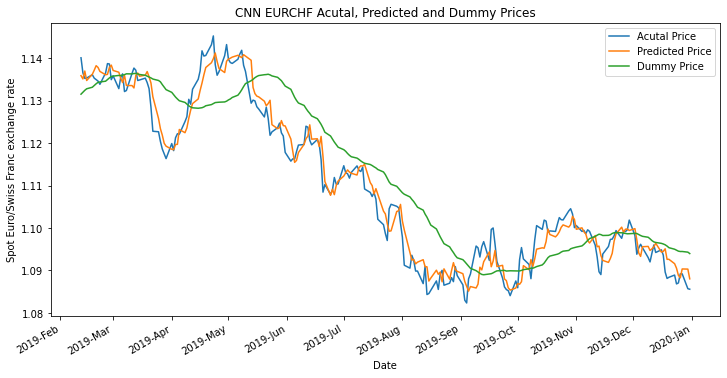

In [14]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

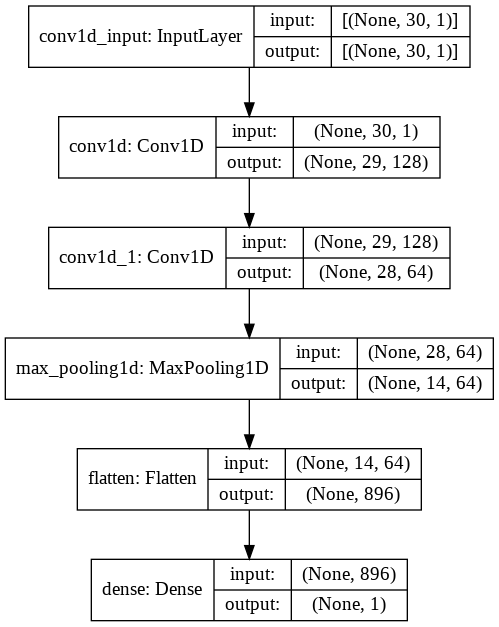

In [15]:
plot_model(model, show_shapes=True, expand_nested=True)

In [16]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0029243871014015188
RMSE:  0.054077602585557716
MAE:  0.043019817950869885
Dummy MSE:  0.01696823190684472
Dummy RMSE:  0.13026216606077423
Dummy MAE:  0.10864031818078547


In [17]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_EURCHF/assets
